# IMPORTS

In [ ]:
!pip install pyyaml==5.1

In [ ]:
# install detectron2:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss

# To obtain pretrained models
from detectron2 import model_zoo
# Predictor
from detectron2.engine import DefaultPredictor
# Set config
from detectron2.config import get_cfg
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
# to obtain metadata
from detectron2.data import MetadataCatalog
# to display an image
from google.colab.patches import cv2_imshow


# GET DATA

In [ ]:
# mount drive
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [ ]:
dir = "drive/MyDrive/Cricket-Shot-Classification/"

In [ ]:
# Get labels
folders = os.listdir( dir + "data/")
print(folders)

['sweep', 'cut', 'drive', 'pull']


In [ ]:
# for dealing with images

images  = []
labels  = []

for folder in folders:
    names = os.listdir(dir + "data/" + folder)
    for name in names:
        img = cv2.imread(dir + "data/" + folder + '/' + name)
        images.append(img)        
        labels.append(folder)

In [ ]:
# number of images
len(images)

282

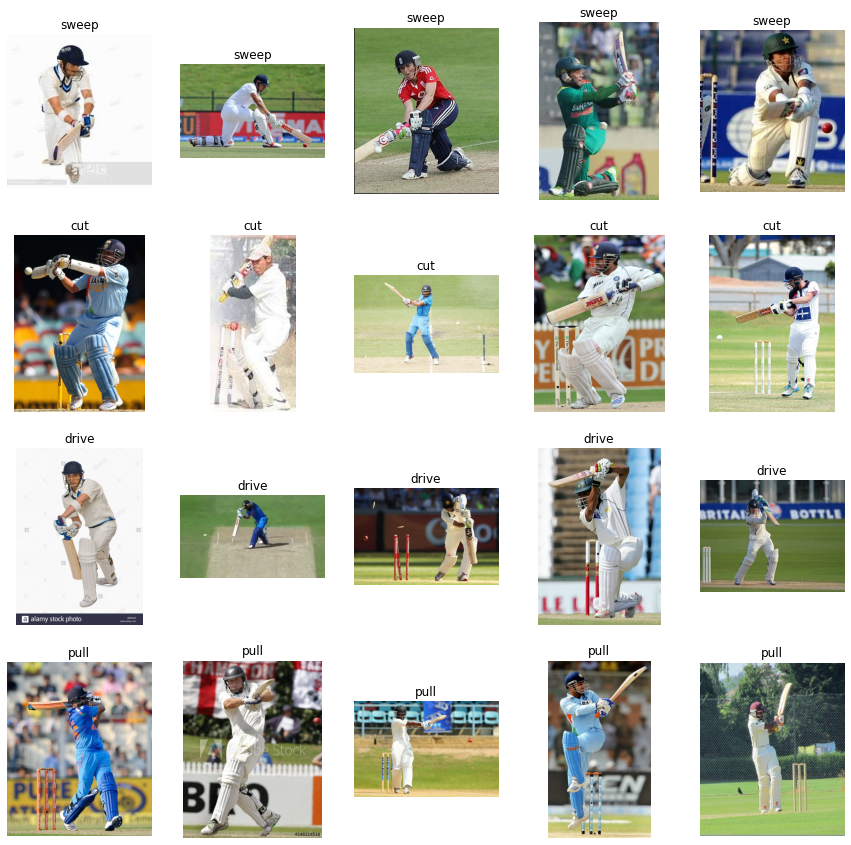

In [ ]:
# create subplots with 4 rows and 5 columns
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

for i in range(len(folders)):
    names = os.listdir(dir + "data/" + folders[i])
    names = random.sample(names, 5)
    for j in range(len(names)):
      img = cv2.imread(dir + "data/" + folders[i] + '/' + names[j])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax[i, j].imshow(img)
      ax[i, j].set_title(folders[i])
      ax[i, j].axis('off')

# DATA AUGMENTATION

In [ ]:
# image augmentation
aug_images=[]
aug_labels=[]

for idx in range(len(images)):

  img  = images[idx]
  label= labels[idx]

  # flip an image
  img_flip = cv2.flip(img, 1)

  aug_images.append(img_flip)
  aug_labels.append(label)  

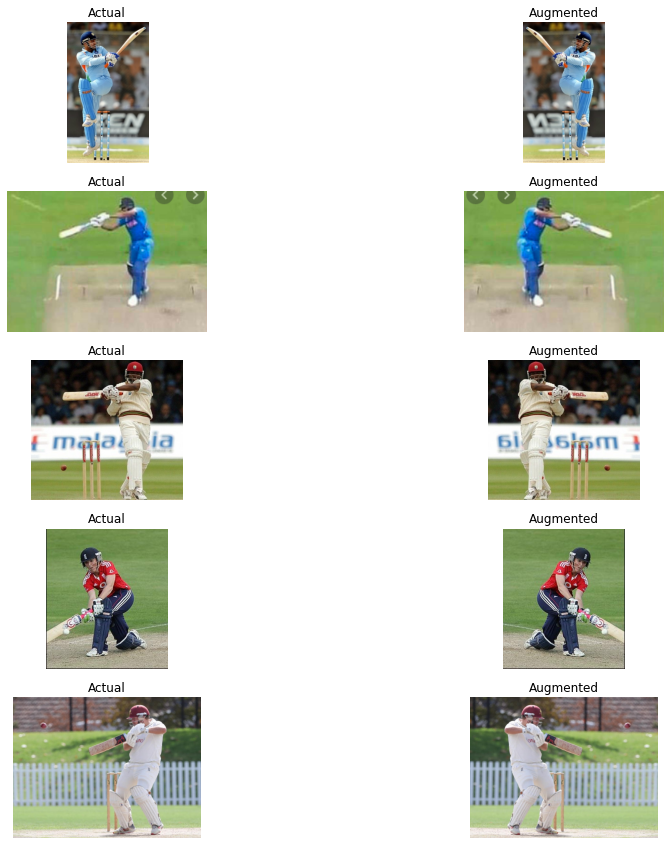

In [ ]:
# display actual and augmented image for sample images

# create indices
ind = range(len(aug_images))

# randomly sample indices
ind = random.sample(ind, 5)

# create subplots with 5 rows and 2 columns
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))

for row in range(5):
  for col in range(2):
    
    # first column for actual image
    if col == 0:
      ax[row, col].imshow(images[ind[row]][:, :, ::-1])
      ax[row, col].set_title('Actual')
      ax[row, col].axis('off')

    # second column for augmented image
    else:      
      ax[row, col].imshow(aug_images[ind[row]][:, :, ::-1])
      ax[row, col].set_title('Augmented')
      ax[row, col].axis('off')

In [ ]:
# combine actual and augmented images & labels
images = images + aug_images
labels = labels + aug_labels

In [ ]:
# number of images
len(images)

564

# GETTING KEYPOINTS

In [ ]:
# define configure instance
cfg = get_cfg()

# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

# download pretrained model 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  

# create predictor
predictor = DefaultPredictor(cfg)

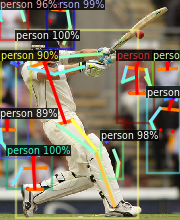

In [ ]:
# randomly select images
for img in random.sample(images,1):    
  
    # make predictions
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale = 0.4)
    
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to('cpu'))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):  
  
  # make predictions
  outputs = predictor(img)
  
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  
  kp = keypoints.to('cpu').numpy()
  
  # if keypoints detected
  if(len(keypoints)>0):
    
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    
    # convert 2D array to 1D array
    kp = kp.flatten()
    
    return kp

In [ ]:
keypoints   = []

for i in tqdm(range(len(images))):
  
  # extract keypoints
  kp = extract_keypoints(images[i])
  keypoints.append(kp)


100%|██████████| 564/564 [01:43<00:00,  5.46it/s]


# GETTING POSE FROM KEYPOINTS

In [ ]:
# for normalization
scaler = StandardScaler()
keypoints = scaler.fit_transform(keypoints)
keypoints = np.array(keypoints)

In [ ]:
# converting the target categories into numbers
le = LabelEncoder()
y = le.fit_transform(labels)

In [ ]:
# for creating training and validation sets
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels, random_state=120)

In [ ]:
# converting the keypoints and target value to tensor
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)

y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)

y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

In [ ]:
# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([451, 34]), torch.Size([451])),
 (torch.Size([113, 34]), torch.Size([113])))

In [ ]:
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   Linear(64, 32),
                   ReLU(),
                   Linear(32, 16),
                   ReLU(),
                   Linear(16, 4),
                   Softmax()
                   )

In [ ]:
# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
def train(epoch):

    model.train()
    tr_loss = 0

    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%10 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val.item())

In [ ]:
n_epochs = 1000

# training the model
for epoch in range(n_epochs):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch :  1 	 loss : 1.3862018585205078
Epoch :  11 	 loss : 1.2696990966796875
Epoch :  21 	 loss : 1.0834407806396484
Epoch :  31 	 loss : 1.0254883766174316
Epoch :  41 	 loss : 1.000993251800537
Epoch :  51 	 loss : 1.0059477090835571
Epoch :  61 	 loss : 1.0001001358032227
Epoch :  71 	 loss : 0.9898688197135925
Epoch :  81 	 loss : 0.9758967161178589
Epoch :  91 	 loss : 0.9585134387016296
Epoch :  101 	 loss : 0.9798622727394104
Epoch :  111 	 loss : 0.9907190799713135
Epoch :  121 	 loss : 0.9841881394386292
Epoch :  131 	 loss : 0.9711760878562927
Epoch :  141 	 loss : 0.9725525379180908
Epoch :  151 	 loss : 0.9414989352226257
Epoch :  161 	 loss : 0.9657337665557861
Epoch :  171 	 loss : 0.97486412525177
Epoch :  181 	 loss : 0.9705072045326233
Epoch :  191 	 loss : 0.9612028002738953
Epoch :  201 	 loss : 0.9604591727256775
Epoch :  211 	 loss : 0.9517489671707153
Epoch :  221 	 loss : 0.9602295160293579
Epoch :  231 	 loss : 0.9575052261352539
Epoch :  241 	 loss : 0.957687

# EVALUATION

In [ ]:
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)
if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)
accuracy_score(y_val.cpu(), final_pred)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.7699115044247787